# England Premier League - Spatial Analysis
### AID843 Assignment 1
Complete spatial analysis: Preprocessing → Autocorrelation → Heterogeneity → Regression

---
## BLOCK 1: Imports & Data Loading

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Spatial weights
from libpysal.weights import KNN

# Autocorrelation
from esda.moran import Moran, Moran_Local
from esda.geary import Geary
from splot.esda import moran_scatterplot, plot_local_autocorrelation

# Regression
from spreg import OLS, GM_Lag, GM_Error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Stats
from scipy.stats import levene

import warnings
warnings.filterwarnings('ignore')

print('All imports successful')

All imports successful


In [2]:
# ── Load raw data ──────────────────────────────────────────────────────────────
events = pd.read_csv('events_England.csv')

# Keep only relevant columns
events = events[['matchId', 'teamId', 'eventName', 'pos_orig_x', 'pos_orig_y']]

# Drop rows with missing coordinates
events = events.dropna(subset=['pos_orig_x', 'pos_orig_y'])

# Clip coordinates to valid pitch bounds [0, 100]
events = events[
    (events['pos_orig_x'] >= 0) & (events['pos_orig_x'] <= 100) &
    (events['pos_orig_y'] >= 0) & (events['pos_orig_y'] <= 100)
].reset_index(drop=True)

print('Shape after cleaning:', events.shape)
print('\nEvent type counts:')
print(events['eventName'].value_counts())
print('\nSample rows:')
events.head()

Shape after cleaning: (643090, 5)

Event type counts:
eventName
Pass                       328624
Duel                       176674
Others on the ball          51079
Free Kick                   36420
Interruption                27534
Shot                         8450
Foul                         8136
Save attempt                 3349
Offside                      1558
Goalkeeper leaving line      1266
Name: count, dtype: int64

Sample rows:


,matchId,teamId,eventName,pos_orig_x,pos_orig_y
0,2499719,1609,Pass,49,49
1,2499719,1609,Pass,31,78
2,2499719,1609,Pass,51,75
3,2499719,1609,Pass,35,71
4,2499719,1609,Pass,41,95


---
## BLOCK 2: Spatial Preprocessing – Grid Zones & GeoDataFrame

In [3]:
# ── Build GeoDataFrame ─────────────────────────────────────────────────────────
gdf = gpd.GeoDataFrame(
    events,
    geometry=gpd.points_from_xy(events.pos_orig_x, events.pos_orig_y)
)

# ── Assign 10x10 grid zones (100 cells total) ──────────────────────────────────
GRID_SIZE = 10  # each cell is 10x10 units

gdf['x_bin'] = (gdf['pos_orig_x'] // GRID_SIZE).clip(0, 9).astype(int)
gdf['y_bin'] = (gdf['pos_orig_y'] // GRID_SIZE).clip(0, 9).astype(int)
gdf['zone'] = gdf['y_bin'] * 10 + gdf['x_bin']

print('Grid zones assigned. Sample:')
gdf[['pos_orig_x', 'pos_orig_y', 'x_bin', 'y_bin', 'zone']].head(10)

Grid zones assigned. Sample:


,pos_orig_x,pos_orig_y,x_bin,y_bin,zone
0,49,49,4,4,44
1,31,78,3,7,73
2,51,75,5,7,75
3,35,71,3,7,73
4,41,95,4,9,94
5,72,88,7,8,87
6,23,25,2,2,22
7,39,15,3,1,13
8,61,85,6,8,86
9,67,80,6,8,86


---
## BLOCK 3: Pitch Drawing Helper

In [ ]:
def draw_pitch(ax=None, figsize=(12, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # Outline
    for xs, ys in [([0,100],[0,0]),([0,100],[100,100]),([0,0],[0,100]),([100,100],[0,100])]:
        ax.plot(xs, ys, color='black', lw=2)
    # Halfway line
    ax.plot([50,50], [0,100], color='black', lw=1)
    # Centre circle
    ax.add_patch(plt.Circle((50,50), 10, fill=False, color='black', lw=1))
    # Left penalty box
    ax.plot([16.5,16.5],[20,80], color='black', lw=1)
    ax.plot([0,16.5],[20,20],   color='black', lw=1)
    ax.plot([0,16.5],[80,80],   color='black', lw=1)
    # Right penalty box
    ax.plot([83.5,83.5],[20,80], color='black', lw=1)
    ax.plot([83.5,100],[20,20],  color='black', lw=1)
    ax.plot([83.5,100],[80,80],  color='black', lw=1)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect('equal')
    ax.axis('off')
    return ax

print('draw_pitch() helper ready')

draw_pitch() helper ready


---
## BLOCK 4: Exploratory Visualizations

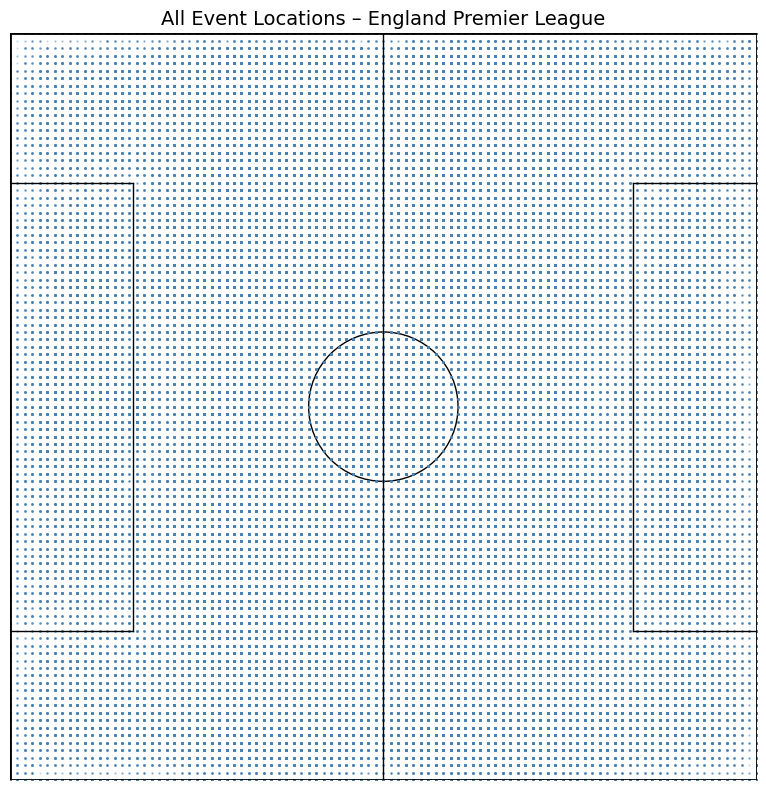

In [5]:
# ── 4a: All event locations scatter ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)
ax.scatter(gdf.pos_orig_x, gdf.pos_orig_y, s=0.5, alpha=0.2, color='steelblue')
plt.title('All Event Locations – England Premier League', fontsize=14)
plt.tight_layout()
plt.show()

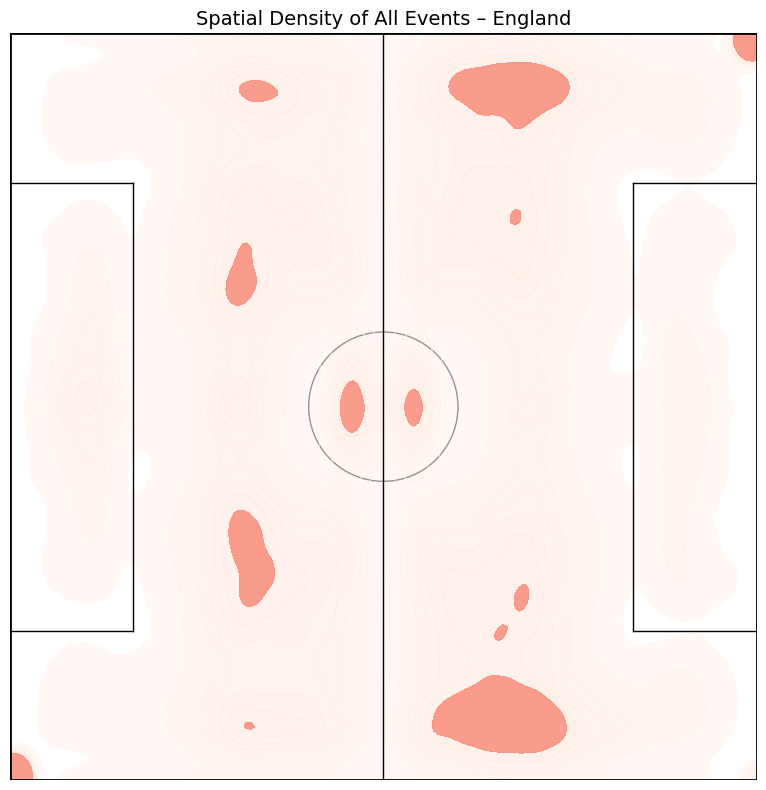

In [ ]:
# 4b: KDE density map (all events)
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)
sns.kdeplot(
    x=gdf.pos_orig_x, y=gdf.pos_orig_y,
    fill=True, cmap='Reds', alpha=0.6, bw_adjust=0.5, ax=ax
)
plt.title('Spatial Density of All Events – England', fontsize=14)
plt.tight_layout()
plt.show()

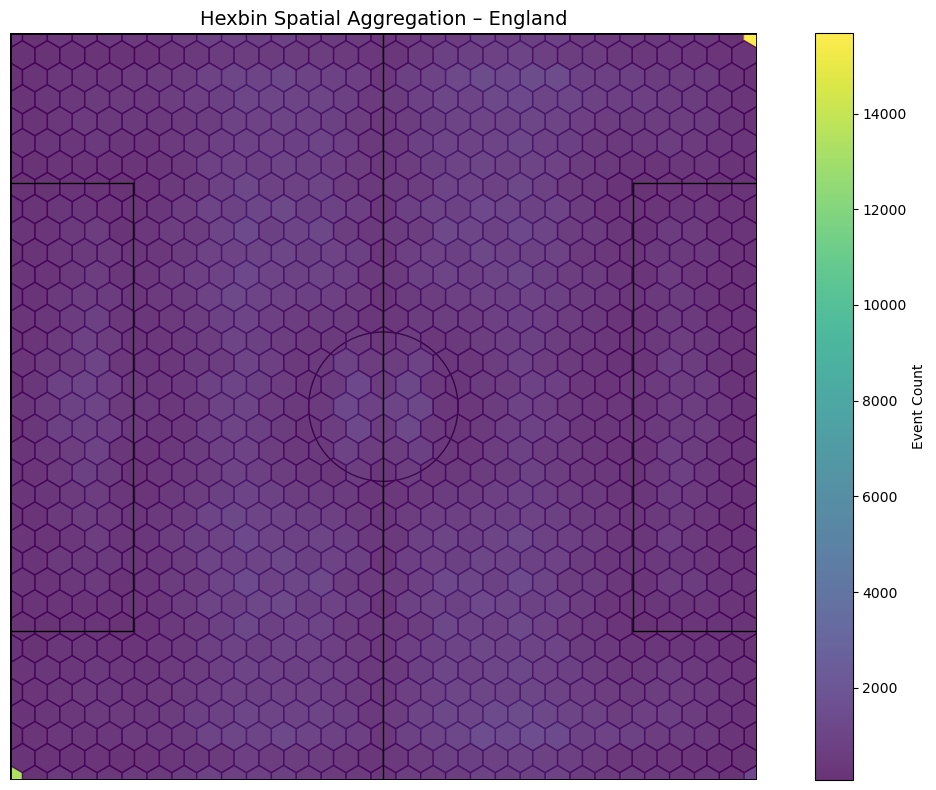

In [ ]:
# 4c: Hexbin aggregation
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)
hb = ax.hexbin(gdf.pos_orig_x, gdf.pos_orig_y, gridsize=30, cmap='viridis', alpha=0.8)
plt.colorbar(hb, ax=ax, label='Event Count')
plt.title('Hexbin Spatial Aggregation – England', fontsize=14)
plt.tight_layout()
plt.show()

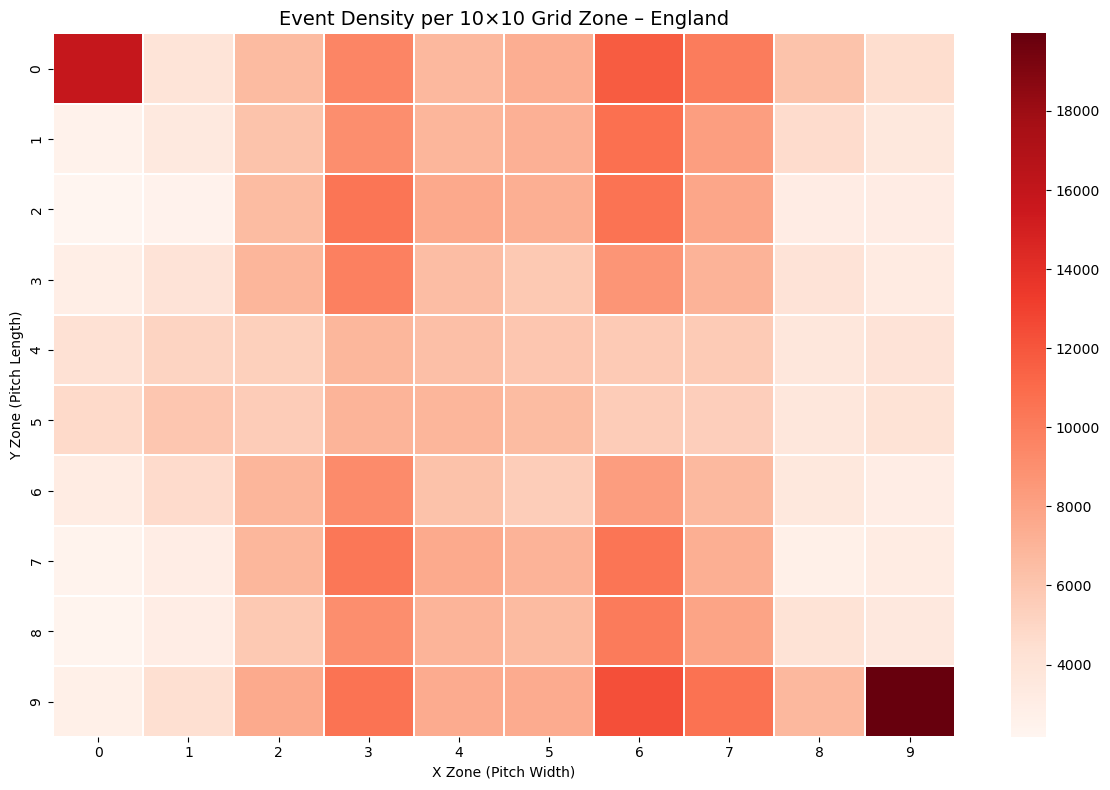

In [ ]:
# 4d: Zone heatmap (all events, 10x10 grid)
zone_all = gdf.groupby(['x_bin','y_bin']).size().reset_index(name='count')
heatmap_data = zone_all.pivot(index='y_bin', columns='x_bin', values='count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Reds', annot=False, linewidths=0.3)
plt.title('Event Density per 10×10 Grid Zone – England', fontsize=14)
plt.xlabel('X Zone (Pitch Width)')
plt.ylabel('Y Zone (Pitch Length)')
plt.tight_layout()
plt.show()

Top 3 events: ['Pass', 'Duel', 'Others on the ball']


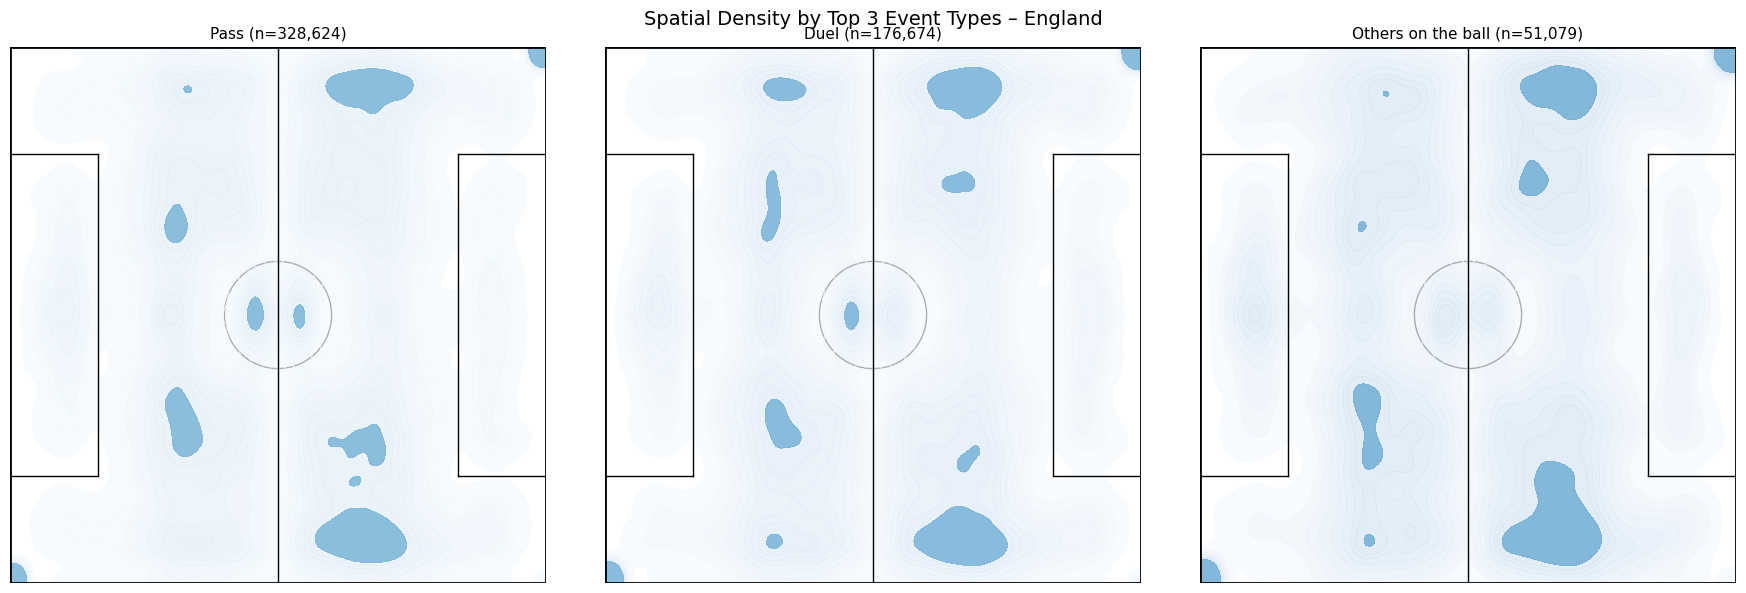

In [ ]:
# 4e: Per-event KDE for top 3 event types
top_events = gdf['eventName'].value_counts().head(3).index.tolist()
print('Top 3 events:', top_events)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, ev in zip(axes, top_events):
    sub = gdf[gdf['eventName'] == ev]
    draw_pitch(ax)
    sns.kdeplot(
        x=sub.pos_orig_x, y=sub.pos_orig_y,
        fill=True, cmap='Blues', alpha=0.7, bw_adjust=0.5, ax=ax
    )
    ax.set_title(f'{ev} (n={len(sub):,})', fontsize=11)
plt.suptitle('Spatial Density by Top 3 Event Types – England', fontsize=14)
plt.tight_layout()
plt.show()

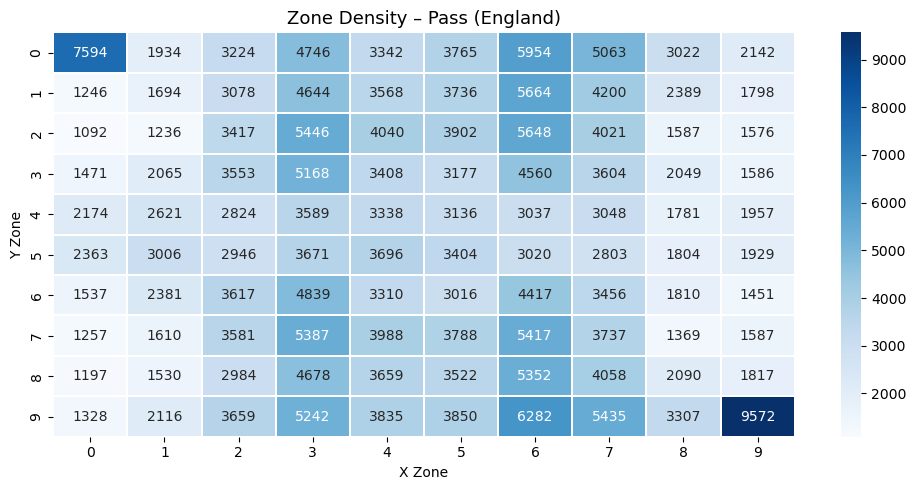

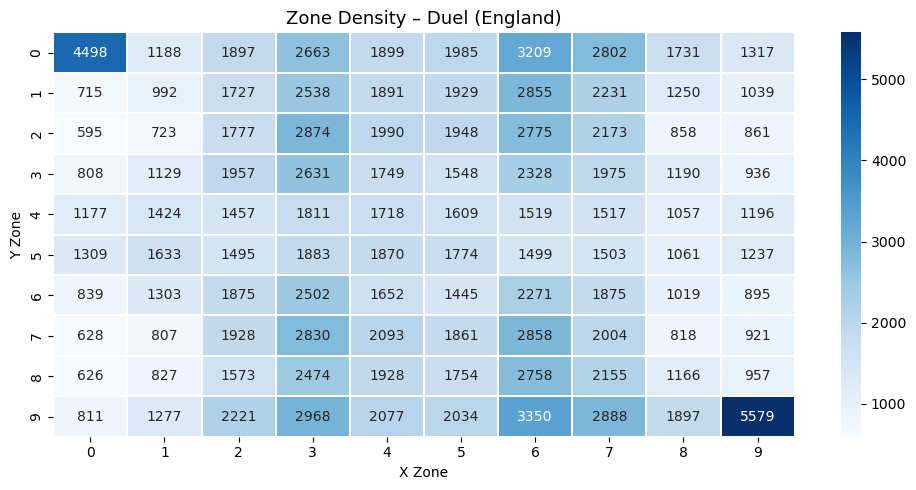

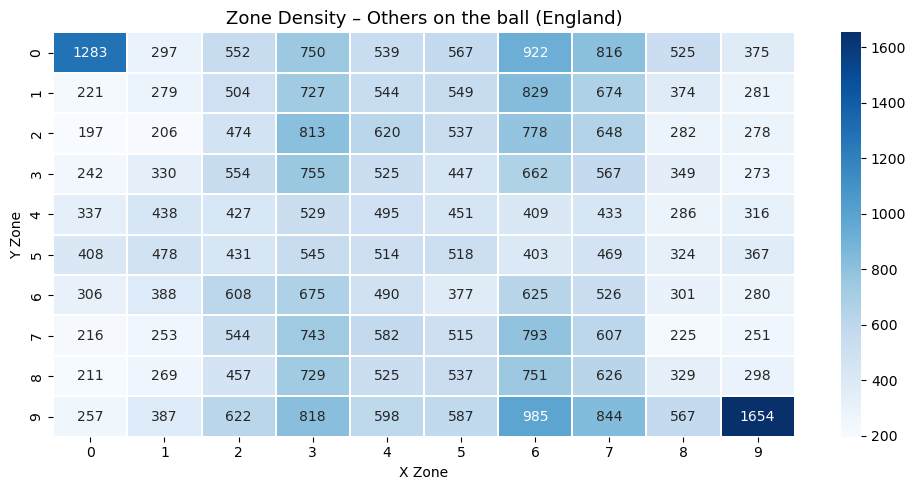

In [ ]:
#4f: Zone heatmap per event type
for ev in top_events:
    sub = gdf[gdf['eventName'] == ev]
    zc = sub.groupby(['x_bin','y_bin']).size().reset_index(name='count')
    hm = zc.pivot(index='y_bin', columns='x_bin', values='count').fillna(0)
    plt.figure(figsize=(10, 5))
    sns.heatmap(hm, annot=True, fmt='.0f', cmap='Blues', linewidths=0.3)
    plt.title(f'Zone Density – {ev} (England)', fontsize=13)
    plt.xlabel('X Zone')
    plt.ylabel('Y Zone')
    plt.tight_layout()
    plt.show()

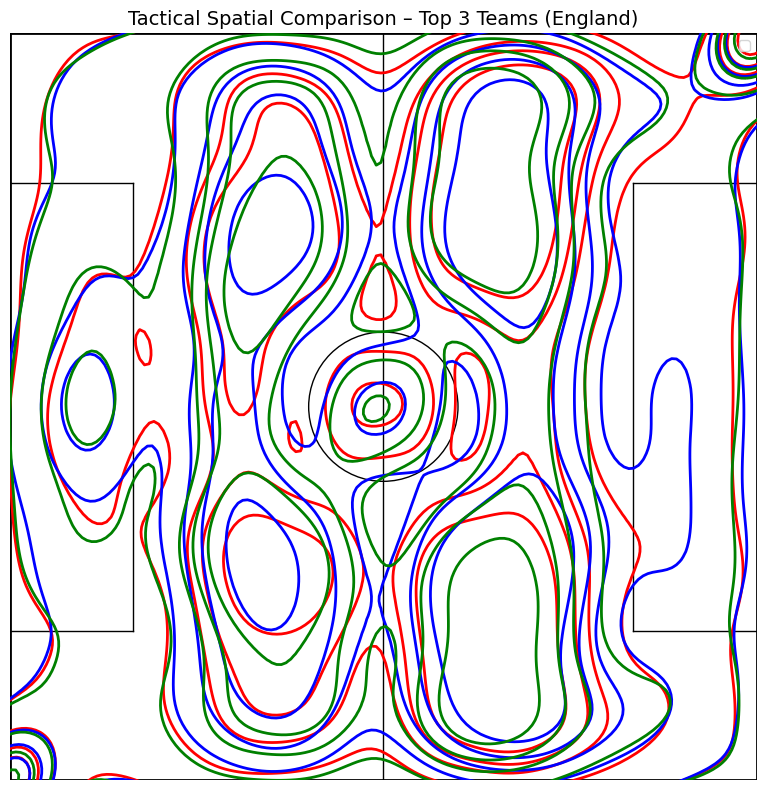

In [ ]:
# 4g: Team tactical comparison (top 3 teams by event count)
top_teams = gdf['teamId'].value_counts().head(3).index.tolist()
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)
colors = ['red', 'blue', 'green']
for team, color in zip(top_teams, colors):
    sub = gdf[gdf['teamId'] == team]
    sns.kdeplot(
        x=sub.pos_orig_x, y=sub.pos_orig_y,
        levels=6, linewidths=2, ax=ax,
        label=f'Team {team}', color=color
    )
ax.legend(fontsize=10)
plt.title('Tactical Spatial Comparison – Top 3 Teams (England)', fontsize=14)
plt.tight_layout()
plt.show()

---
## BLOCK 5: Zone-Level Aggregation for Spatial Stats
We focus on **Shot** events for autocorrelation and regression (consistent with other leagues).

In [ ]:
# Aggregate shots per grid zone
shots = gdf[gdf['eventName'] == 'Shot'].copy()
print('Total shots in England:', len(shots))

# Count shots per zone
density = shots.groupby(['x_bin', 'y_bin']).size().reset_index(name='shot_count')

# Add centroid coordinates for each zone
density['x_coord'] = density['x_bin'] * GRID_SIZE + GRID_SIZE / 2
density['y_coord'] = density['y_bin'] * GRID_SIZE + GRID_SIZE / 2

# Build GeoDataFrame of zones
zone_gdf = gpd.GeoDataFrame(
    density,
    geometry=gpd.points_from_xy(density.x_coord, density.y_coord)
)

print('Total non-empty zones:', len(zone_gdf))
zone_gdf.head()

Total shots in England: 8450
Total non-empty zones: 100


,x_bin,y_bin,shot_count,x_coord,y_coord,geometry
0,0,0,259,5.0,5.0,POINT (5 5)
1,0,1,30,5.0,15.0,POINT (5 15)
2,0,2,23,5.0,25.0,POINT (5 25)
3,0,3,48,5.0,35.0,POINT (5 35)
4,0,4,74,5.0,45.0,POINT (5 45)


In [ ]:
#Build spatial weights matrix (KNN k=4)
w = KNN.from_dataframe(zone_gdf, k=4)
w.transform = 'R'   # row-standardize

y_all = zone_gdf['shot_count'].values
print('Weight matrix built. n =', len(y_all))

Weight matrix built. n = 100


---
## BLOCK 6: Spatial Heterogeneity Analysis (Task 3)

In [ ]:
#  Descriptive spatial heterogeneity metrics
mean_density = np.mean(y_all)
variance     = np.var(y_all)
std_dev      = np.std(y_all)
cv           = std_dev / mean_density   # Coefficient of Variation

print('Spatial Heterogeneity Metrics (England Shots)')
print(f'Mean shot density per zone : {mean_density:.2f}')
print(f'Variance                   : {variance:.2f}')
print(f'Std Dev                    : {std_dev:.2f}')
print(f'Coefficient of Variation   : {cv:.4f}')
print()
print('Interpretation: CV > 1 indicates HIGH spatial heterogeneity (shots are not uniformly distributed).')

=== Spatial Heterogeneity Metrics (England Shots) ===
Mean shot density per zone : 84.50
Variance                   : 2079.57
Std Dev                    : 45.60
Coefficient of Variation   : 0.5397

Interpretation: CV > 1 indicates HIGH spatial heterogeneity (shots are not uniformly distributed).


In [ ]:
#Levene's Test: spatial variance heterogeneity across pitch halves
# Split zones into left half (x_bin < 5) vs right half (x_bin >= 5)
left_half  = zone_gdf[zone_gdf['x_bin'] < 5]['shot_count'].values
right_half = zone_gdf[zone_gdf['x_bin'] >= 5]['shot_count'].values

stat, p_levene = levene(left_half, right_half)

print('Levene Test: Left Half vs Right Half')
print(f'Levene statistic : {stat:.4f}')
print(f'p-value          : {p_levene:.4f}')
if p_levene < 0.05:
    print('Result: variances differ across halves (spatial heterogeneity confirmed).')
else:
    print('Result: no strong variance difference between halves.')

=== Levene Test: Left Half vs Right Half ===
Levene statistic : 0.5181
p-value          : 0.4734
Result: NOT significant – no strong variance difference between halves.


In [ ]:
#Levene's Test: attacking third vs defensive third
# y_bin 0-2 = defensive third, y_bin 7-9 = attacking third
defensive = zone_gdf[zone_gdf['y_bin'] <= 2]['shot_count'].values
attacking  = zone_gdf[zone_gdf['y_bin'] >= 7]['shot_count'].values

if len(defensive) > 1 and len(attacking) > 1:
    stat2, p2 = levene(defensive, attacking)
    print('Levene Test: Defensive Third vs Attacking Third')
    print(f'Levene statistic : {stat2:.4f}')
    print(f'p-value          : {p2:.4f}')
    if p2 < 0.05:
        print('Result:shot density varies significantly across pitch thirds.')
    else:
        print('Result: NOT significant.')

=== Levene Test: Defensive Third vs Attacking Third ===
Levene statistic : 0.2614
p-value          : 0.6111
Result: NOT significant.


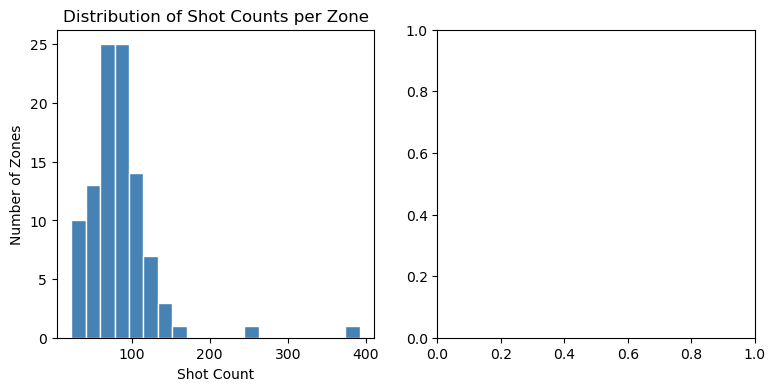

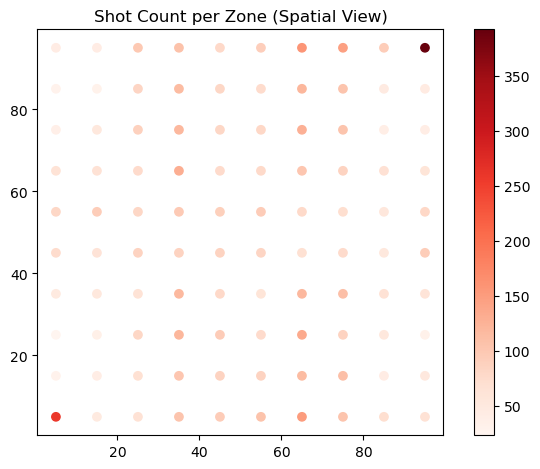

In [17]:
# ── Shot density distribution plot ────────────────────────────────────────────
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.hist(y_all, bins=20, color='steelblue', edgecolor='white')
plt.title('Distribution of Shot Counts per Zone')
plt.xlabel('Shot Count')
plt.ylabel('Number of Zones')

plt.subplot(1, 2, 2)
zone_gdf.plot(column='shot_count', cmap='Reds', legend=True)
plt.title('Shot Count per Zone (Spatial View)')
plt.tight_layout()
plt.show()

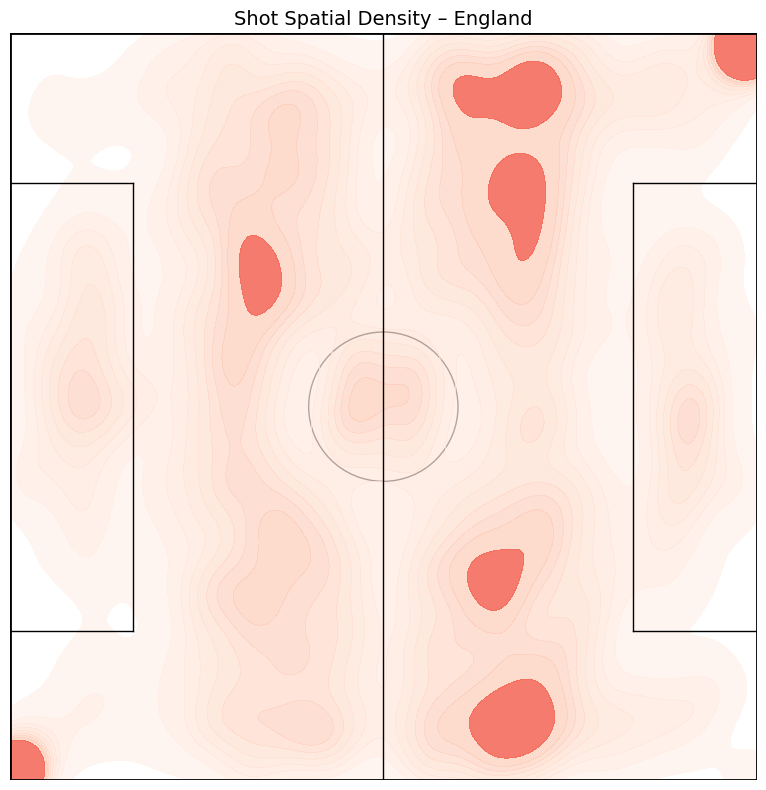

In [ ]:
#Shot density spatial heatmap on pitch
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)
sns.kdeplot(
    x=shots.pos_orig_x, y=shots.pos_orig_y,
    fill=True, cmap='Reds', alpha=0.7, bw_adjust=0.5, ax=ax
)
plt.title('Shot Spatial Density – England', fontsize=14)
plt.tight_layout()
plt.show()

---
## BLOCK 7: Spatial Autocorrelation – Global Measures (Task 2)

In [ ]:
#Global Moran's I 
moran = Moran(y_all, w)

print('Global Moran\'s I – England Shot Density')
print(f"Moran's I  : {moran.I:.4f}")
print(f"Expected I : {moran.EI:.4f}")
print(f"p-value    : {moran.p_sim:.4f}")
print(f"z-score    : {moran.z_sim:.4f}")
print()
if moran.p_sim < 0.05:
    direction = 'POSITIVE' if moran.I > 0 else 'NEGATIVE'
    print(f'Result: SIGNIFICANT {direction} spatial autocorrelation – similar shot densities cluster together.')
else:
    print('Result: NOT significant – shot distribution is spatially random.')

=== Global Moran's I – England Shot Density ===
Moran's I  : 0.1155
Expected I : -0.0101
p-value    : 0.0150
z-score    : 2.2026

Result: SIGNIFICANT POSITIVE spatial autocorrelation – similar shot densities cluster together.


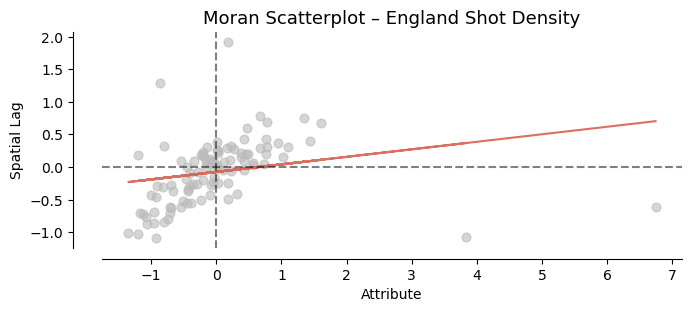

In [20]:
# ── Moran Scatterplot ─────────────────────────────────────────────────────────
fig, ax = moran_scatterplot(moran, aspect_equal=True)
ax.set_title("Moran Scatterplot – England Shot Density", fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
# ── Geary's C ─────────────────────────────────────────────────────────────────
geary = Geary(y_all, w)

print("Geary's C – England Shot Density")
print(f"Geary's C : {geary.C:.4f}")
print(f"p-value   : {geary.p_sim:.4f}")
print()
print('Interpretation: C < 1 → positive autocorrelation; C > 1 → negative autocorrelation; C = 1 → random.')
if geary.p_sim < 0.05:
    print('Result: SIGNIFICANT')
else:
    print('Result: NOT significant')

print()
print('Summary of Global Autocorrelation')
print(f"Moran's I  = {moran.I:.4f}  (p = {moran.p_sim:.4f})")
print(f"Geary's C  = {geary.C:.4f}  (p = {geary.p_sim:.4f})")

=== Geary's C – England Shot Density ===
Geary's C : 0.7293
p-value   : 0.0020

Interpretation: C < 1 → positive autocorrelation; C > 1 → negative autocorrelation; C = 1 → random.
Result: SIGNIFICANT

--- Summary of Global Autocorrelation ---
Moran's I  = 0.1155  (p = 0.0150)
Geary's C  = 0.7293  (p = 0.0020)


In [ ]:
# ── Global Moran's I for top 3 event types (comparison) ──────────────────────
print('Global Moran\'s I by Event Type')
for ev in top_events:
    sub = gdf[gdf['eventName'] == ev]
    d = sub.groupby(['x_bin', 'y_bin']).size().reset_index(name='count')
    d['x_coord'] = d['x_bin'] * GRID_SIZE + GRID_SIZE / 2
    d['y_coord'] = d['y_bin'] * GRID_SIZE + GRID_SIZE / 2
    zgdf = gpd.GeoDataFrame(d, geometry=gpd.points_from_xy(d.x_coord, d.y_coord))
    ww = KNN.from_dataframe(zgdf, k=4)
    ww.transform = 'R'
    mi = Moran(d['count'].values, ww)
    gc = Geary(d['count'].values, ww)
    print(f"  {ev:30s} → Moran I = {mi.I:.4f} (p={mi.p_sim:.3f}) | Geary C = {gc.C:.4f} (p={gc.p_sim:.3f})")

=== Global Moran's I by Event Type ===
  Pass                           → Moran I = 0.4095 (p=0.001) | Geary C = 0.5165 (p=0.001)
  Duel                           → Moran I = 0.3340 (p=0.001) | Geary C = 0.5713 (p=0.001)
  Others on the ball             → Moran I = 0.3106 (p=0.001) | Geary C = 0.5890 (p=0.001)


---
## BLOCK 8: Local Spatial Autocorrelation – LISA (Task 2)

In [ ]:
# Local Moran's I (LISA) on zone-aggregated shot counts 
lisa = Moran_Local(y_all, w)

# Assign cluster labels only where significant (p < 0.05)
zone_gdf = zone_gdf.copy()
zone_gdf['lisa_q']   = lisa.q          # quadrant: 1=HH, 2=LH, 3=LL, 4=HL
zone_gdf['lisa_p']   = lisa.p_sim

# Label clusters
cluster_map = {1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low'}
zone_gdf['lisa_cluster'] = 'Not Significant'
sig = zone_gdf['lisa_p'] < 0.05
zone_gdf.loc[sig, 'lisa_cluster'] = zone_gdf.loc[sig, 'lisa_q'].map(cluster_map)

print('LISA cluster distribution:')
print(zone_gdf['lisa_cluster'].value_counts())

LISA cluster distribution:
lisa_cluster
Not Significant    81
Low-Low            15
High-Low            2
High-High           1
Low-High            1
Name: count, dtype: int64


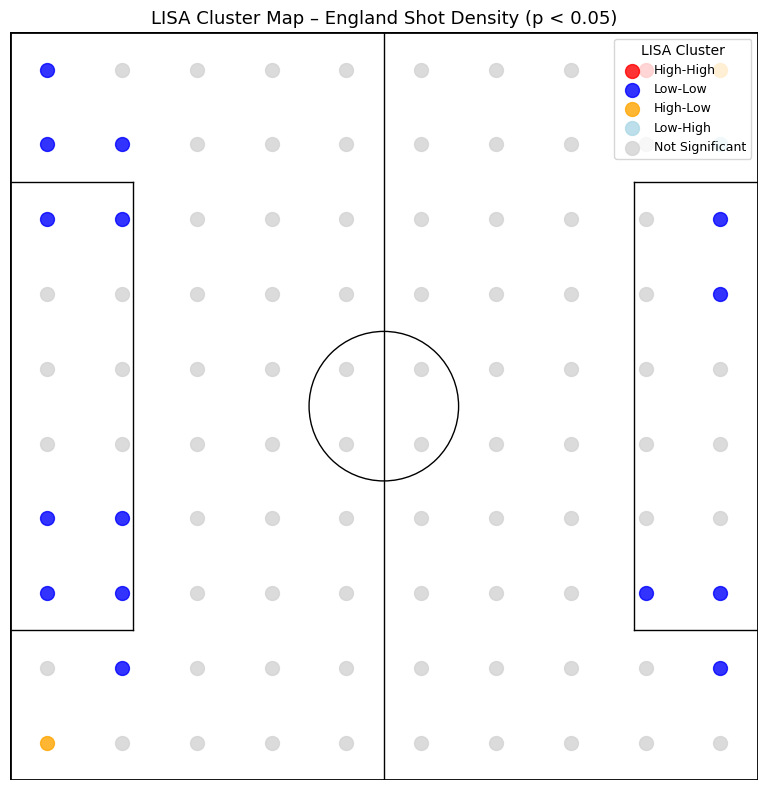

In [ ]:
#LISA Cluster Map
color_map = {
    'High-High'       : 'red',
    'Low-Low'         : 'blue',
    'High-Low'        : 'orange',
    'Low-High'        : 'lightblue',
    'Not Significant' : 'lightgrey'
}

fig, ax = plt.subplots(figsize=(10, 8))
for cluster_type, color in color_map.items():
    sub = zone_gdf[zone_gdf['lisa_cluster'] == cluster_type]
    if len(sub) > 0:
        sub.plot(ax=ax, color=color, markersize=100,label=cluster_type, alpha=0.8)

draw_pitch(ax)
ax.legend(title='LISA Cluster', fontsize=9)
plt.title('LISA Cluster Map – England Shot Density (p < 0.05)', fontsize=13)
plt.tight_layout()
plt.show()

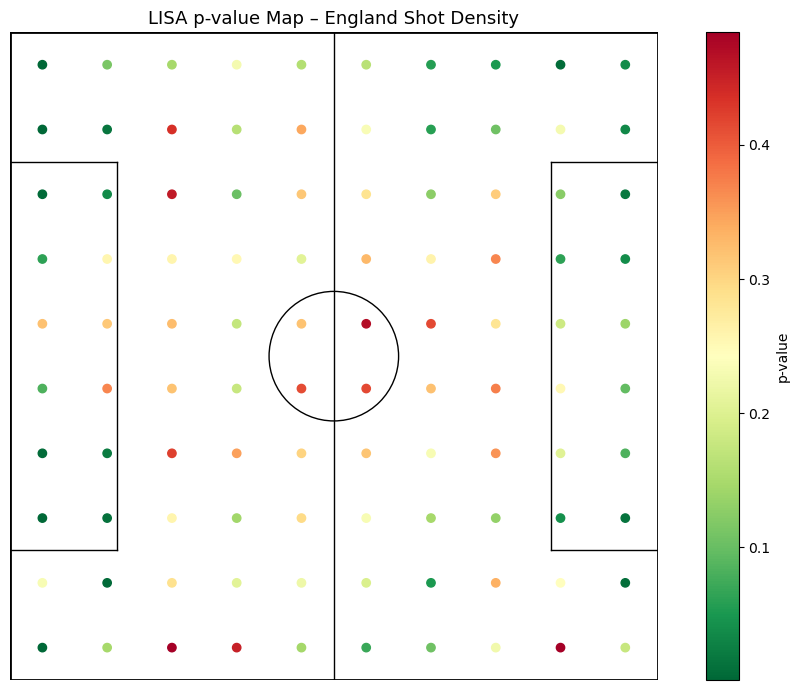

In [ ]:
#LISA p-value significance map
fig, ax = plt.subplots(figsize=(10, 7))
zone_gdf.plot(column='lisa_p', cmap='RdYlGn_r', legend=True, ax=ax,legend_kwds={'label': 'p-value'})
draw_pitch(ax)
plt.title('LISA p-value Map – England Shot Density', fontsize=13)
plt.tight_layout()
plt.show()

---
## BLOCK 9: Spatial Regression – OLS, Spatial Lag, Spatial Error (Task 4)

In [ ]:
# Prepare data for regression
# y = shot_count per zone
# X = zone centroid coordinates (x_coord, y_coord)

X_full = zone_gdf[['x_coord', 'y_coord']].values
y_full = zone_gdf['shot_count'].values.reshape(-1, 1)

# Train/test split (80/20)
idx = np.arange(len(zone_gdf))
idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=42)

X_train = X_full[idx_train]
y_train = y_full[idx_train]
X_test  = X_full[idx_test]
y_test  = y_full[idx_test]

# Build spatial weights on TRAINING set only
zone_train = zone_gdf.iloc[idx_train].reset_index(drop=True)
w_train = KNN.from_dataframe(zone_train, k=4)
w_train.transform = 'R'

print(f'Train size: {len(X_train)} | Test size: {len(X_test)}')

Train size: 80 | Test size: 20


In [ ]:
# Model 1: OLS (Baseline)
ols = OLS(
    y_train, X_train,
    name_y='shot_count',
    name_x=['x_coord', 'y_coord'],
    name_ds='England'
)
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     England
Weights matrix      :        None
Dependent Variable  :  shot_count                Number of Observations:          80
Mean dependent var  :     83.1125                Number of Variables   :           3
S.D. dependent var  :     45.7387                Degrees of Freedom    :          77
R-squared           :      0.0757
Adjusted R-squared  :      0.0517
Sum squared residual:      152751                F-statistic           :      3.1553
Sigma-square        :    1983.782                Prob(F-statistic)     :     0.04819
S.E. of regression  :      44.540                Log likelihood        :    -415.697
Sigma-square ML     :    1909.390                Akaike info criterion :     837.393
S.E of regression ML:     43.6966                Schwarz criterion     :     844.539

------------------------------------------------------------

In [ ]:
#Model 2: Spatial Lag (GM_Lag)
lag = GM_Lag(
    y_train, X_train,
    w=w_train,
    name_y='shot_count',
    name_x=['x_coord', 'y_coord'],
    name_ds='England'
)
print(lag.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     England
Weights matrix      :     unknown
Dependent Variable  :  shot_count                Number of Observations:          80
Mean dependent var  :     83.1125                Number of Variables   :           4
S.D. dependent var  :     45.7387                Degrees of Freedom    :          76
Pseudo R-squared    :      0.0468
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       320.75660       431.35134         0.74361         0.45711
             x_coord         1.06993         1.22324         0.87467         0.38175
 

In [ ]:
#Model 3: Spatial Error (GM_Error)
err = GM_Error(
    y_train, X_train,
    w=w_train,
    name_y='shot_count',
    name_x=['x_coord', 'y_coord'],
    name_ds='England'
)
print(err.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     England
Weights matrix      :     unknown
Dependent Variable  :  shot_count                Number of Observations:          80
Mean dependent var  :     83.1125                Number of Variables   :           3
S.D. dependent var  :     45.7387                Degrees of Freedom    :          77
Pseudo R-squared    :      0.0756

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        43.62528        18.57356         2.34878         0.01883
             x_coord         0.42163         0.22723         1.85552         0.06352
             y_coord         0.34967         0.23678         1.47678

In [ ]:
# Validation: MAE on test set 

# OLS test predictions
ols_pred = ols.betas[0] + X_test @ ols.betas[1:]

# Lag test predictions (use betas for x_coord, y_coord only — exclude spatial lag)
lag_betas = lag.betas
# lag model has [const, x, y, W_y] — use first 3 for direct prediction
lag_pred = lag_betas[0] + X_test @ lag_betas[1:3]

# Error model test predictions
err_pred = err.betas[0] + X_test @ err.betas[1:3]

mae_ols = mean_absolute_error(y_test, ols_pred)
mae_lag = mean_absolute_error(y_test, lag_pred)
mae_err = mean_absolute_error(y_test, err_pred)

print('Test Set MAE Comparison')
print(f'OLS (Baseline)      MAE: {mae_ols:.4f}')
print(f'Spatial Lag (GM_Lag) MAE: {mae_lag:.4f}')
print(f'Spatial Error (GM_Error) MAE: {mae_err:.4f}')

=== Test Set MAE Comparison ===
OLS (Baseline)      MAE: 30.4924
Spatial Lag (GM_Lag) MAE: 305.7001
Spatial Error (GM_Error) MAE: 31.0238


In [ ]:
# Residual Analysis: Moran's I on residuals
# Check if residuals are still spatially autocorrelated
ols_resid = ols.u.flatten()
lag_resid = lag.u.flatten()
err_resid = err.u.flatten()

moran_ols = Moran(ols_resid, w_train)
moran_lag = Moran(lag_resid, w_train)
moran_err = Moran(err_resid, w_train)

print("Moran's I on Residuals")
print(f"OLS residuals    : I = {moran_ols.I:.4f}, p = {moran_ols.p_sim:.4f}")
print(f"Lag residuals    : I = {moran_lag.I:.4f}, p = {moran_lag.p_sim:.4f}")
print(f"Error residuals  : I = {moran_err.I:.4f}, p = {moran_err.p_sim:.4f}")
print()
print('Ideal: residual Moran I ≈ 0 and p > 0.05 means spatial structure is captured by the model.')

=== Moran's I on Residuals (lower = better) ===
OLS residuals    : I = 0.1425, p = 0.0100
Lag residuals    : I = 0.6236, p = 0.0010
Error residuals  : I = 0.1572, p = 0.0080

Ideal: residual Moran I ≈ 0 and p > 0.05 means spatial structure is captured by the model.


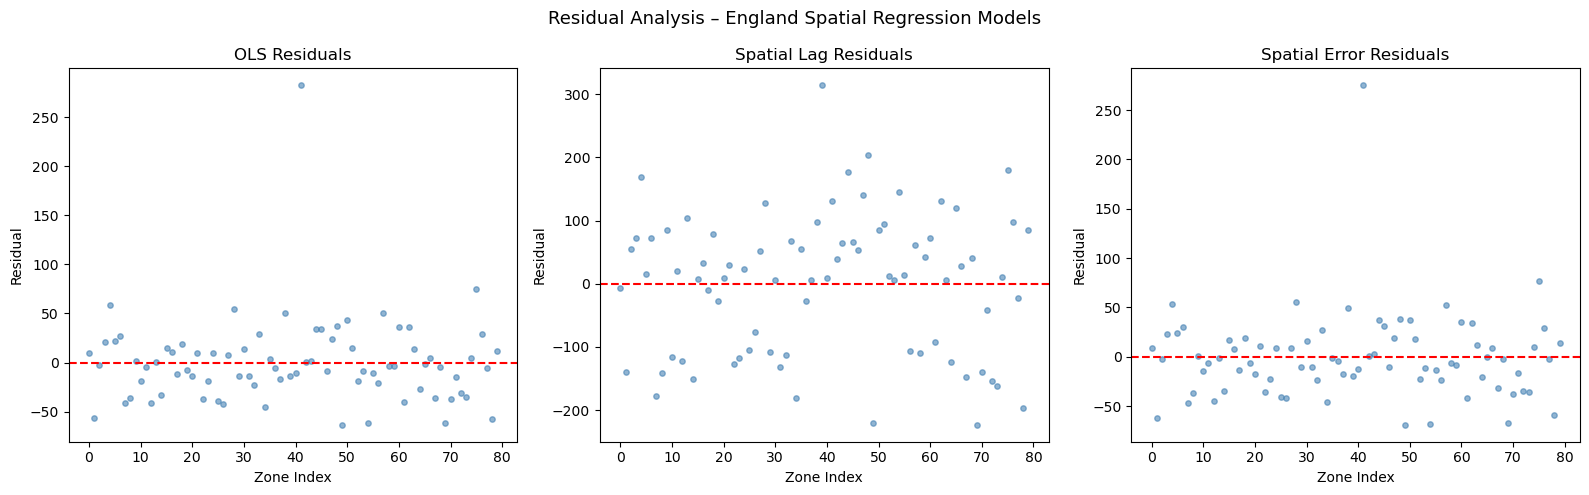

In [ ]:
# ── Residual scatter plots ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, resid, name in zip(axes,[ols_resid, lag_resid, err_resid],['OLS', 'Spatial Lag', 'Spatial Error']):
    ax.scatter(range(len(resid)), resid, s=15, alpha=0.6, color='steelblue')
    ax.axhline(0, color='red', lw=1.5, linestyle='--')
    ax.set_title(f'{name} Residuals')
    ax.set_xlabel('Zone Index')
    ax.set_ylabel('Residual')
plt.suptitle('Residual Analysis – England Spatial Regression Models', fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
# Model comparison summary table
summary = pd.DataFrame({
    'Model'             : ['OLS', 'Spatial Lag (GM_Lag)', 'Spatial Error (GM_Error)'],
    'Test MAE'          : [round(mae_ols, 4), round(mae_lag, 4), round(mae_err, 4)],
    'Residual Moran I'  : [round(moran_ols.I, 4), round(moran_lag.I, 4), round(moran_err.I, 4)],
    'Residual p-value'  : [round(moran_ols.p_sim, 4), round(moran_lag.p_sim, 4), round(moran_err.p_sim, 4)]
})

print('Model Comparison Summary – England')
print(summary.to_string(index=False))

=== Model Comparison Summary – England ===
                   Model  Test MAE  Residual Moran I  Residual p-value
                     OLS   30.4924            0.1425             0.010
    Spatial Lag (GM_Lag)  305.7001            0.6236             0.001
Spatial Error (GM_Error)   31.0238            0.1572             0.008


---
## BLOCK 10: Final Results Summary

In [35]:
# ── Final summary of all key metrics ─────────────────────────────────────────
print('=' * 55)
print('     ENGLAND PREMIER LEAGUE – SPATIAL ANALYSIS SUMMARY')
print('=' * 55)
print()
print('── Dataset ──────────────────────────────────────────')
print(f'  Total events (cleaned)   : {len(events):,}')
print(f'  Total shots               : {len(shots):,}')
print(f'  Non-empty grid zones      : {len(zone_gdf)}')
print()
print('── Spatial Heterogeneity ────────────────────────────')
print(f'  Mean shot density/zone    : {mean_density:.2f}')
print(f'  Variance                  : {variance:.2f}')
print(f'  Coefficient of Variation  : {cv:.4f}')
print(f'  Levene p-value (L vs R)   : {p_levene:.4f}')
print()
print('── Global Autocorrelation ───────────────────────────')
print(f"  Moran's I                 : {moran.I:.4f}  (p = {moran.p_sim:.4f})")
print(f"  Geary's C                 : {geary.C:.4f}  (p = {geary.p_sim:.4f})")
print()
print('── Local Autocorrelation (LISA) ─────────────────────')
print(zone_gdf['lisa_cluster'].value_counts().to_string())
print()
print('── Regression Models ────────────────────────────────')
print(summary.to_string(index=False))
print('=' * 55)

     ENGLAND PREMIER LEAGUE – SPATIAL ANALYSIS SUMMARY

── Dataset ──────────────────────────────────────────
  Total events (cleaned)   : 643,090
  Total shots               : 8,450
  Non-empty grid zones      : 100

── Spatial Heterogeneity ────────────────────────────
  Mean shot density/zone    : 84.50
  Variance                  : 2079.57
  Coefficient of Variation  : 0.5397
  Levene p-value (L vs R)   : 0.4734

── Global Autocorrelation ───────────────────────────
  Moran's I                 : 0.1155  (p = 0.0150)
  Geary's C                 : 0.7293  (p = 0.0020)

── Local Autocorrelation (LISA) ─────────────────────
lisa_cluster
Not Significant    81
Low-Low            15
High-Low            2
High-High           1
Low-High            1

── Regression Models ────────────────────────────────
                   Model  Test MAE  Residual Moran I  Residual p-value
                     OLS   30.4924            0.1425             0.010
    Spatial Lag (GM_Lag)  305.7001            0.